# Attention Sink Implementation 

## Modules to import

In [1]:
import torch
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/sriney/miniconda3/envs/hawai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Module loading and cuda 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-large"
generation_length = 512  # The number of tokens to generate for the test

print(f"Using device: {device}")
print(f"Loading model: {model_name}")

# --- Load Model and Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

print("Setup complete.")

Using device: cuda
Loading model: gpt2-large
Setup complete.


## Analysis Code

In [6]:
def analyze_inference(strategy, window_size=None, sink_size=4):
    """
    Generates tokens using a simulated larger batch size to stress the GPU.
    """
    print(f"\n--- Running test for strategy: '{strategy}' ---")
    
    # Use the model's max length to create the biggest possible cache
    generation_length = model.config.n_positions  # This is 1024 for gpt2-large
    dummy_batch_size = 32 # This is what will make the GPU work harder
    
    # Start with a single token, expanded to our dummy batch size
    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    input_ids = input_ids.expand(dummy_batch_size, -1)
    
    past_key_values = None
    timings = []
    
    with torch.no_grad():
        for i in range(generation_length - 1): # Generate up to the max length
            start_time = time.perf_counter()

            # --- Simple, Reliable Forward Pass ---
            outputs = model(input_ids=input_ids, past_key_values=past_key_values, use_cache=True)
            
            # Get the next predicted token (we only need one from the batch for our logic)
            next_token_logits = outputs.logits[0, -1, :]
            next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

            # The input for the next step is the new token, expanded to the batch size
            input_ids = next_token_id.expand(dummy_batch_size, -1)
            past_key_values = outputs.past_key_values

            # --- KV Cache Eviction Logic ---
            if past_key_values is None:
                end_time = time.perf_counter()
                timings.append((end_time - start_time) * 1000)
                continue

            current_cache_size = past_key_values[0][0].shape[2]

            if strategy == 'attention_sink' and current_cache_size > window_size:
                past_key_values = tuple(
                    (
                        torch.cat([layer_past[0][:, :, :sink_size, :], layer_past[0][:, :, -(window_size - sink_size):, :]], dim=2),
                        torch.cat([layer_past[1][:, :, :sink_size, :], layer_past[1][:, :, -(window_size - sink_size):, :]], dim=2)
                    ) for layer_past in past_key_values
                )

            end_time = time.perf_counter()
            timings.append((end_time - start_time) * 1000)

            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length-1} tokens...")
    
    print(f"'{strategy}' test complete.")
    return timings

## Main code to run 

In [ ]:
# --- Run the Two Experiments ---
window = 128
sink = 4  # The number of initial tokens to always keep

baseline_timings = analyze_inference(strategy='baseline')
attention_sink_timings = analyze_inference(strategy='attention_sink', window_size=window, sink_size=sink)


--- Running test for strategy: 'baseline' ---
Generated 100/1023 tokens...
Generated 200/1023 tokens...
Generated 300/1023 tokens...
Generated 400/1023 tokens...
Generated 500/1023 tokens...


## Plotting the results

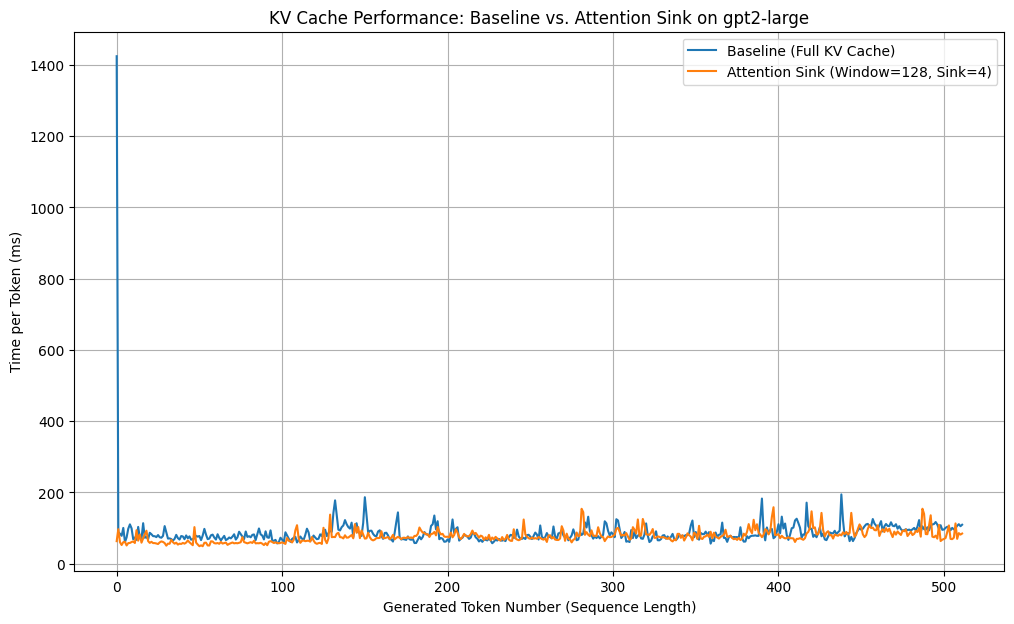

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(baseline_timings, label='Baseline (Full KV Cache)')
plt.plot(attention_sink_timings, label=f'Attention Sink (Window={window}, Sink={sink})')

plt.xlabel('Generated Token Number (Sequence Length)')
plt.ylabel('Time per Token (ms)')
plt.title(f'KV Cache Performance: Baseline vs. Attention Sink on {model_name}')
plt.legend()
plt.grid(True)
plt.show()